<a href="https://colab.research.google.com/github/adamquah/NLP-Coursework/blob/main/Sentiment_analysis_demo_(movie).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import regex as re
from string import punctuation
import math

import nltk
nltk.download("omw-1.4")
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
data = pd.read_csv('Movies.csv')

In [ ]:
data.head(10)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [ ]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

# 1.0 Data Cleaning

In [ ]:
data[data['review'].duplicated() == True]

,review,sentiment
3537,Quite what the producers of this appalling ada...,negative
3769,My favourite police series of all time turns t...,positive
4391,"Beautiful film, pure Cassavetes style. Gena Ro...",positive
6352,If you liked the Grinch movie... go watch that...,negative
6479,I want very much to believe that the above quo...,negative
...,...,...
49912,This is an incredible piece of drama and power...,positive
49950,This was a very brief episode that appeared in...,negative
49984,Hello it is I Derrick Cannon and I welcome you...,negative
49986,This movie is a disgrace to the Major League F...,negative


In [ ]:
data.drop_duplicates(subset='review', inplace=True)

In [ ]:
data.describe()

,review,sentiment
count,49582,49582
unique,49582,2
top,One of the other reviewers has mentioned that ...,positive
freq,1,24884


In [ ]:
def remove_punc(series):
    temp = re.sub(f'[{punctuation}]', '', series)
    temp = re.sub(' br br ',' ', temp)
    temp = re.sub(' n ',' ', temp)
    return temp

data['review'] = data['review'].apply(remove_punc)

In [ ]:
data[['review']].head()


,review
0,One of the other reviewers has mentioned that ...
1,A wonderful little production The filming tech...
2,I thought this was a wonderful way to spend ti...
3,Basically theres a family where a little boy J...
4,Petter Matteis Love in the Time of Money is a ...


In [ ]:
def remove_stop(series):
    return ' '.join([x.lower() for x in series.split(' ') if x.lower() not in STOPWORDS])

data['review'] = data['review'].apply(remove_stop)

In [ ]:
data[['review']]

,review
0,one reviewers mentioned watching 1 oz episode ...
1,wonderful little production filming technique ...
2,thought wonderful way spend time hot summer we...
3,basically theres family little boy jake thinks...
4,petter matteis love time money visually stunni...
...,...
49995,thought movie right good job wasnt creative or...
49996,bad plot bad dialogue bad acting idiotic direc...
49997,catholic taught parochial elementary schools n...
49998,im going disagree previous comment side maltin...


# 2.0 Tokenization

In [ ]:
pip install nltk

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize

def tokenize(text):
    return word_tokenize(text)

data['tokens'] = data['review'].apply(tokenize)


In [ ]:
data['token_len'] = data['tokens'].apply(len)
data[['tokens','token_len']].head()

,tokens,token_len
0,"[one, reviewers, mentioned, watching, 1, oz, e...",167
1,"[wonderful, little, production, filming, techn...",84
2,"[thought, wonderful, way, spend, time, hot, su...",88
3,"[basically, theres, family, little, boy, jake,...",71
4,"[petter, matteis, love, time, money, visually,...",128


In [ ]:
data.describe()

,token_len
count,49582.000000
mean,120.137268
std,90.716578
min,3.000000
25%,64.000000
50%,89.000000
75%,146.000000
max,1432.000000


##2.1 Padding

In [ ]:
MAX_LEN = math.ceil(data.describe().values[1])
print(MAX_LEN)

121


<ipython-input-20-75024c704cdb>:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  MAX_LEN = math.ceil(data.describe().values[1])


In [ ]:
def pad_token(series):
    if len(series) < MAX_LEN:
        series.extend(['<END>']*(MAX_LEN-len(series)))
        return series
    else:
        return series[:MAX_LEN]

data['paded_tokens'] = data['tokens'].apply(pad_token)

In [ ]:
print(data['paded_tokens'].values[10])

['phil', 'alien', 'one', 'quirky', 'films', 'humour', 'based', 'around', 'oddness', 'everything', 'rather', 'actual', 'punchlinesbr', 'br', 'first', 'odd', 'pretty', 'funny', 'movie', 'progressed', 'didnt', 'find', 'jokes', 'oddness', 'funny', 'anymorebr', 'br', 'low', 'budget', 'film', 'thats', 'never', 'problem', 'pretty', 'interesting', 'characters', 'eventually', 'lost', 'interestbr', 'br', 'imagine', 'film', 'appeal', 'stoner', 'currently', 'partakingbr', 'br', 'something', 'similar', 'better', 'try', 'brother', 'another', 'planet', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>

In [ ]:
data[['tokens','paded_tokens']]

,tokens,paded_tokens
0,"[one, reviewers, mentioned, watching, 1, oz, e...","[one, reviewers, mentioned, watching, 1, oz, e..."
1,"[wonderful, little, production, filming, techn...","[wonderful, little, production, filming, techn..."
2,"[thought, wonderful, way, spend, time, hot, su...","[thought, wonderful, way, spend, time, hot, su..."
3,"[basically, theres, family, little, boy, jake,...","[basically, theres, family, little, boy, jake,..."
4,"[petter, matteis, love, time, money, visually,...","[petter, matteis, love, time, money, visually,..."
...,...,...
49995,"[thought, movie, right, good, job, wasnt, crea...","[thought, movie, right, good, job, wasnt, crea..."
49996,"[bad, plot, bad, dialogue, bad, acting, idioti...","[bad, plot, bad, dialogue, bad, acting, idioti..."
49997,"[catholic, taught, parochial, elementary, scho...","[catholic, taught, parochial, elementary, scho..."
49998,"[im, going, disagree, previous, comment, side,...","[im, going, disagree, previous, comment, side,..."


# 3.0 Normalization

## 3.1 Lemmetization

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
import nltk

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def lemma(series):
    return [lemmatizer.lemmatize(word) for word in series]

data['lemma_tokens'] = data['paded_tokens'].apply(lemma)

In [ ]:
data[['tokens','lemma_tokens']]

,tokens,lemma_tokens
0,"[one, reviewers, mentioned, watching, 1, oz, e...","[one, reviewer, mentioned, watching, 1, oz, ep..."
1,"[wonderful, little, production, filming, techn...","[wonderful, little, production, filming, techn..."
2,"[thought, wonderful, way, spend, time, hot, su...","[thought, wonderful, way, spend, time, hot, su..."
3,"[basically, theres, family, little, boy, jake,...","[basically, there, family, little, boy, jake, ..."
4,"[petter, matteis, love, time, money, visually,...","[petter, matteis, love, time, money, visually,..."
...,...,...
49995,"[thought, movie, right, good, job, wasnt, crea...","[thought, movie, right, good, job, wasnt, crea..."
49996,"[bad, plot, bad, dialogue, bad, acting, idioti...","[bad, plot, bad, dialogue, bad, acting, idioti..."
49997,"[catholic, taught, parochial, elementary, scho...","[catholic, taught, parochial, elementary, scho..."
49998,"[im, going, disagree, previous, comment, side,...","[im, going, disagree, previous, comment, side,..."


##3.2 Stemming

In [ ]:
stemmer = PorterStemmer()

In [ ]:
def stem(series):
    return [stemmer.stem(word) for word in series]

data['stem_tokens'] = data['tokens'].apply(stem)

In [ ]:
data[['tokens','stem_tokens']]

,tokens,stem_tokens
0,"[one, reviewers, mentioned, watching, 1, oz, e...","[one, review, mention, watch, 1, oz, episod, y..."
1,"[wonderful, little, production, filming, techn...","[wonder, littl, product, film, techniqu, unass..."
2,"[thought, wonderful, way, spend, time, hot, su...","[thought, wonder, way, spend, time, hot, summe..."
3,"[basically, theres, family, little, boy, jake,...","[basic, there, famili, littl, boy, jake, think..."
4,"[petter, matteis, love, time, money, visually,...","[petter, mattei, love, time, money, visual, st..."
...,...,...
49995,"[thought, movie, right, good, job, wasnt, crea...","[thought, movi, right, good, job, wasnt, creat..."
49996,"[bad, plot, bad, dialogue, bad, acting, idioti...","[bad, plot, bad, dialogu, bad, act, idiot, dir..."
49997,"[catholic, taught, parochial, elementary, scho...","[cathol, taught, parochi, elementari, school, ..."
49998,"[im, going, disagree, previous, comment, side,...","[im, go, disagre, previou, comment, side, malt..."


# 4.0 POS Tagging

In [ ]:
import nltk

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
from nltk import pos_tag

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [ ]:
def pos_t(series):
    return nltk.pos_tag(series, tagset='universal')

data['pos_tag_tokens'] = data['tokens'].apply(pos_t)

In [ ]:
data[['tokens','pos_tag_tokens']]

,tokens,pos_tag_tokens
0,"[one, reviewers, mentioned, watching, 1, oz, e...","[(one, NUM), (reviewers, NOUN), (mentioned, VE..."
1,"[wonderful, little, production, filming, techn...","[(wonderful, ADJ), (little, ADJ), (production,..."
2,"[thought, wonderful, way, spend, time, hot, su...","[(thought, VERB), (wonderful, ADJ), (way, NOUN..."
3,"[basically, theres, family, little, boy, jake,...","[(basically, ADV), (theres, NOUN), (family, NO..."
4,"[petter, matteis, love, time, money, visually,...","[(petter, NOUN), (matteis, ADV), (love, ADJ), ..."
...,...,...
49995,"[thought, movie, right, good, job, wasnt, crea...","[(thought, VERB), (movie, NOUN), (right, ADV),..."
49996,"[bad, plot, bad, dialogue, bad, acting, idioti...","[(bad, ADJ), (plot, NOUN), (bad, ADJ), (dialog..."
49997,"[catholic, taught, parochial, elementary, scho...","[(catholic, ADJ), (taught, VERB), (parochial, ..."
49998,"[im, going, disagree, previous, comment, side,...","[(im, NOUN), (going, VERB), (disagree, ADJ), (..."


# 5.0 Word Embeddings

In [ ]:
unique_words = set()
for tokens in list(data['lemma_tokens'].values):
    unique_words.update(tokens)

In [ ]:
print('Count of Unique words:', len(unique_words))

Count of Unique words: 142446


In [ ]:
word2idx = {}
for word in unique_words:
    word2idx[word] = len(word2idx)
word2idx['<END>'] = len(word2idx)

In [ ]:
word_embeddings = np.random.rand(len(word2idx), 200)

with open('glove.6B.200d.txt', 'r', encoding='utf-8') as embeds:
    for line in embeds:
        values = line.split()
        word = values[0]
        if word in word2idx:
            coefs = np.asarray(values[1:], dtype='float32')
            word_embeddings[word2idx[word]] = coefs


In [ ]:
print(f'Word embeddings for word {list(word2idx.keys())[300]}:',word_embeddings[300])

Word embeddings for word balcony: [ 0.63323998 -0.38003999 -0.20725     0.61998999 -0.0053849  -0.1849
  0.15843    -0.50266999 -0.39168999  0.33814001  0.18403    -0.048292
  1.4102     -0.53547001  0.079243    0.28327999 -0.015924    0.21689001
  0.063114    0.18504    -0.02095     0.63225001  1.10580003  0.045336
 -0.23511    -0.51508999 -0.042618   -0.74364001 -0.38148001 -0.29718
  0.2359     -0.11341     0.19726001  0.12164    -0.30287001  0.51472998
 -0.031797   -0.32530001  0.35088    -0.063213    0.029358    0.34593001
 -0.08566    -0.0088913   0.24694     0.92653     0.18009     0.33781999
  0.035753    0.44547999  0.11113     0.72830999  0.53091002 -0.17388
 -0.068809    0.82855999  0.49634999 -0.055551   -0.56281     0.55909997
 -0.060506   -0.26464999  0.38389     0.018914   -0.24348    -0.34709001
 -0.49629     0.004718    0.048976   -0.76354003 -0.40557    -0.045348
  0.85087001 -0.1591     -0.35429001 -0.25419    -0.86825001 -0.31626001
 -0.18698999 -0.011721   -0.34586

# 6.0 Vectorization

In [ ]:
vectorizer = CountVectorizer()

In [ ]:
vector_cl = vectorizer.fit_transform([' '.join(tok) for tok in list(data['lemma_tokens'].values)])

In [ ]:
vector_cl.shape

(49582, 141851)

## Vecotrizing the lables

In [ ]:
def label_vec(series):
    return int(series=='positive')

data['sentiment'] = data['sentiment'].apply(label_vec)

In [ ]:
data[['lemma_tokens', 'sentiment']].head()

,lemma_tokens,sentiment
0,"[one, reviewer, mentioned, watching, 1, oz, ep...",1
1,"[wonderful, little, production, filming, techn...",1
2,"[thought, wonderful, way, spend, time, hot, su...",1
3,"[basically, there, family, little, boy, jake, ...",0
4,"[petter, matteis, love, time, money, visually,...",1


# Train model

In [ ]:
vector_cl_train_x, vector_cl_test_x, vector_cl_train_y, vector_cl_test_y = train_test_split(vector_cl, data['sentiment'].values, test_size=0.3, random_state=42)
print(vector_cl_train_x.shape,vector_cl_train_y.shape,vector_cl_test_x.shape,vector_cl_test_y.shape)

(34707, 141851) (34707,) (14875, 141851) (14875,)


In [ ]:
log_reg = LogisticRegression().fit(vector_cl_train_x, vector_cl_train_y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 7.0 Inteference

In [ ]:
pred = log_reg.predict(vector_cl_test_x)

In [ ]:
print('Mean Accuracy:', log_reg.score(vector_cl_test_x, vector_cl_test_y))
print('F1 Score:', f1_score(vector_cl_test_y, pred))

Mean Accuracy: 0.8674285714285714
F1 Score: 0.8691092526217975


In [ ]:
print(log_reg.predict(vectorizer.transform(['This movie was one of the best i watched in recent times'])))
print(log_reg.predict(vectorizer.transform(['This movie was not bad and i really liked it.'])))
print(log_reg.predict(vectorizer.transform(['The cinematics of this movie made my eyes bleed'])))

[1]
[0]
[0]


## Wordcloud

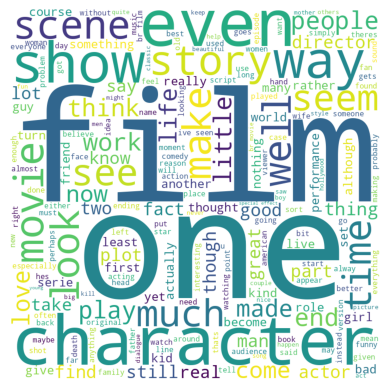

In [ ]:
words = ' '.join(data['review'].values)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10).generate(words)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Hugging face model

In [ ]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, DataCollatorWithPadding, TFAutoModelForSequenceClassification, TrainingArguments, Trainer
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import numpy as np

imdb = load_dataset("imdb")

train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(10000))])
test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(10000))])

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=132)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tokenized_train = tokenized_train.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=32,
)

tokenized_test = tokenized_test.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=32,
)

model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy, "f1": f1}

model.compile(
    optimizer="adam",  # Changed here
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.fit(
    tokenized_train,
    validation_data=tokenized_test,
    epochs=3
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
  3/313 [..............................] - ETA: 2:42:42 - loss: 0.8885 - accuracy: 0.5104

KeyboardInterrupt: 

In [ ]:
from transformers import TextClassificationPipeline
sentiment = TextClassificationPipeline(model=model, tokenizer=tokenizer, framework='tf')

In [ ]:
sentiment(['This movie was one of the best i watched in recent times','This movie was not bad and i really liked it.','The cinematics of this movie made my eyes bleed'])

[{'label': 'LABEL_1', 'score': 0.5008861422538757},
 {'label': 'LABEL_0', 'score': 0.5051156282424927},
 {'label': 'LABEL_0', 'score': 0.5021692514419556}]

In [ ]:
from transformers import TextClassificationPipeline, TFAutoModelForSequenceClassification, AutoTokenizer

# Load the pre-trained DistilBERT model and tokenizer
model_name = "distilbert-base-uncased"
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Create the text classification pipeline
sentiment_pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, framework='tf')

def main():
    print("Welcome to Sentiment Analysis Console!")
    print("Enter a sentence and press Enter to get the sentiment prediction.")
    print("Enter 'exit' to quit.")

    while True:
        user_input = input("Enter a sentence: ").strip()

        if user_input.lower() == 'exit':
            print("Exiting...")
            break

        if user_input:
            try:
                predictions = sentiment_pipeline(user_input)
                sentiment_label = predictions[0]['label']
                sentiment_score = predictions[0]['score']

                print(f"Predicted sentiment: {sentiment_label} (Confidence: {sentiment_score:.2f})")
            except Exception as e:
                print("Error:", e)

if __name__ == "__main__":
    main()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Welcome to Sentiment Analysis Console!
Enter a sentence and press Enter to get the sentiment prediction.
Enter 'exit' to quit.
Predicted sentiment: LABEL_0 (Confidence: 0.53)
Predicted sentiment: LABEL_0 (Confidence: 0.54)
Predicted sentiment: LABEL_0 (Confidence: 0.53)
Predicted sentiment: LABEL_0 (Confidence: 0.52)


KeyboardInterrupt: Interrupted by user